In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("cars_data.csv")


print("Head of the dataset:")
print(df.head())

print("\nDataset Information:")
df.info()

print("\nSummary Statistics:")
print(df.describe())




Head of the dataset:
           model  year    price transmission  mileage fuelType  tax   mpg  \
0            I10  2017   7495.0       Manual    11630   Petrol  145  60.1   
1           Polo  2017  10989.0       Manual     9200   Petrol  145  58.9   
2       2 Series  2019  27990.0    Semi-Auto     1614   Diesel  145  49.6   
3   Yeti Outdoor  2017  12495.0       Manual    30960   Diesel  150  62.8   
4         Fiesta  2017   7999.0       Manual    19353   Petrol  125  54.3   

   engineSize Manufacturer  
0         1.0       hyundi  
1         1.0   volkswagen  
2         2.0          BMW  
3         2.0        skoda  
4         1.2         ford  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97712 entries, 0 to 97711
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         97712 non-null  object 
 1   year          97712 non-null  int64  
 2   price         96727 non-null  floa

In [5]:
df['price']   = df['price']   * 3.75
df['mileage'] = df['mileage'] * 1.60934
df['mpg']     = df['mpg']     * 1.60934 / 4.54609
df.rename(columns={'mpg': 'km_per_L'}, inplace=True)


def model_year_window_mean(sub_df, col, this_year):
    mask = (sub_df['year'].between(this_year - 5, this_year + 5)) & (~sub_df[col].isna())
    return sub_df.loc[mask, col].mean()

for col in ['price', 'tax', 'km_per_L', 'engineSize']:
    for idx, row in df[df[col].isna()].iterrows():
        same_model = df[df['model'] == row['model']]
        val = model_year_window_mean(same_model, col, row['year'])
        if np.isnan(val):
            val = same_model[col].mean()
        if np.isnan(val):
            val = df[col].mean()
        df.at[idx, col] = val


for cat_col in ['fuelType', 'transmission']:
    lookup = df.dropna(subset=[cat_col]).sort_values('year').groupby(['model', 'year'])[cat_col].first()
    for idx, row in df[df[cat_col].isna()].iterrows():
        last_year_val = lookup.get((row['model'], row['year'] - 1), np.nan)
        if pd.isna(last_year_val):
            last_year_val = df.loc[df['model'] == row['model'], cat_col].mode().iloc[0]
        df.at[idx, cat_col] = last_year_val


df = df.dropna(subset=['model', 'Manufacturer'])

print("\nAny missing values left? ->", df.isna().any().any())
print(df)



Any missing values left? -> False
               model  year      price transmission      mileage fuelType  tax  \
0                I10  2017   28106.25       Manual  18716.62420   Petrol  145   
1               Polo  2017   41208.75       Manual  14805.92800   Petrol  145   
2           2 Series  2019  104962.50    Semi-Auto   2597.47476   Diesel  145   
3       Yeti Outdoor  2017   46856.25       Manual  49825.16640   Diesel  150   
4             Fiesta  2017   29996.25       Manual  31145.55702   Petrol  125   
...              ...   ...        ...          ...          ...      ...  ...   
97707         Fiesta  2017   39176.25    Automatic  13417.06758   Petrol  145   
97708       3 Series  2014   56231.25       Manual  40832.17448   Diesel   30   
97709         Fiesta  2017   33562.50       Manual  32041.95940   Petrol  125   
97710          Astra  2017   40125.00    Automatic  39377.33112   Petrol  125   
97711    Grandland X  2019   59242.50       Manual  17036.47324   Diesel  

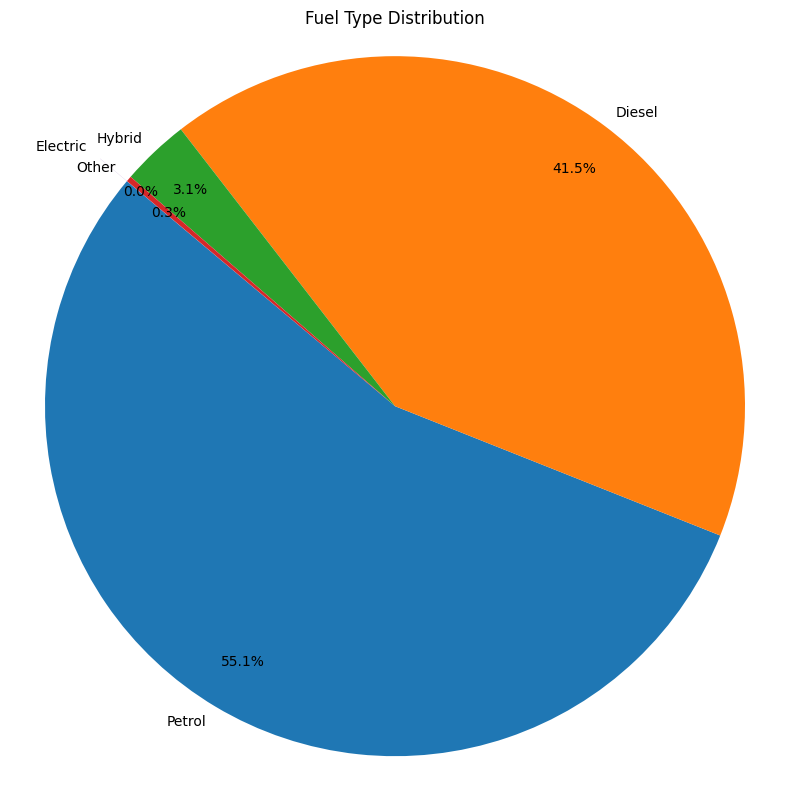

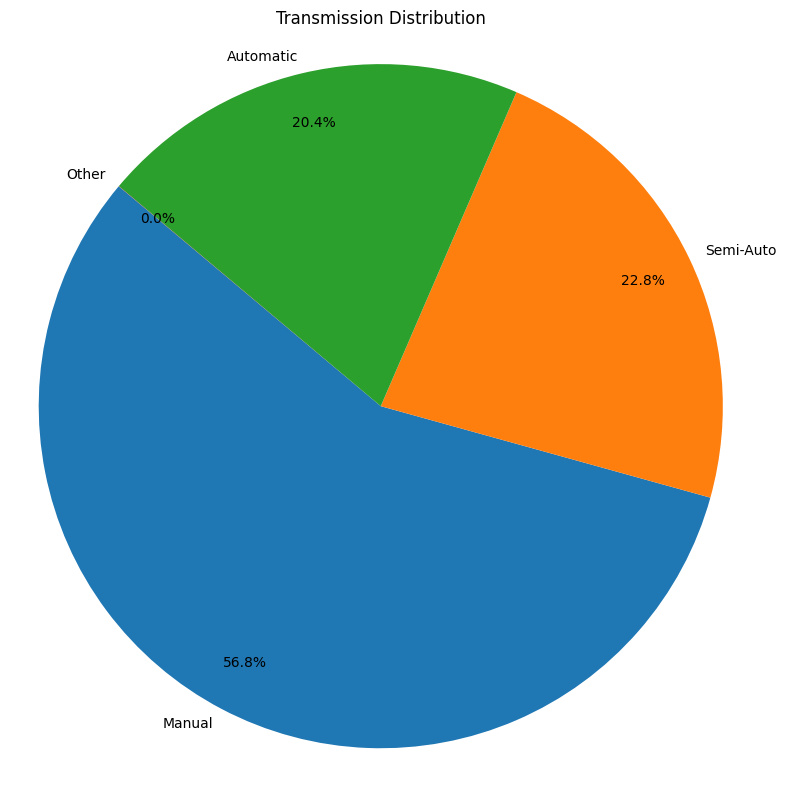

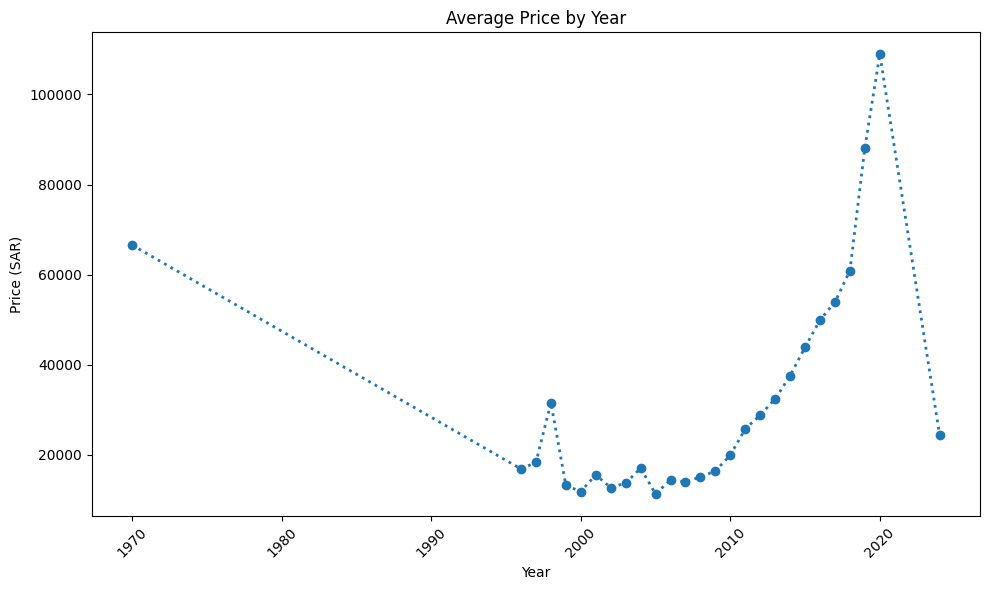

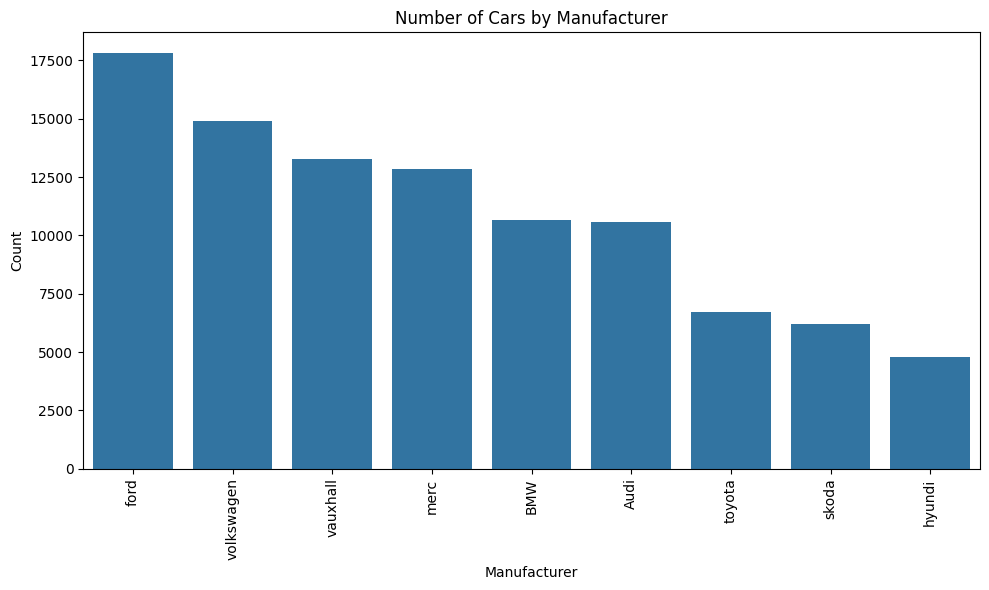

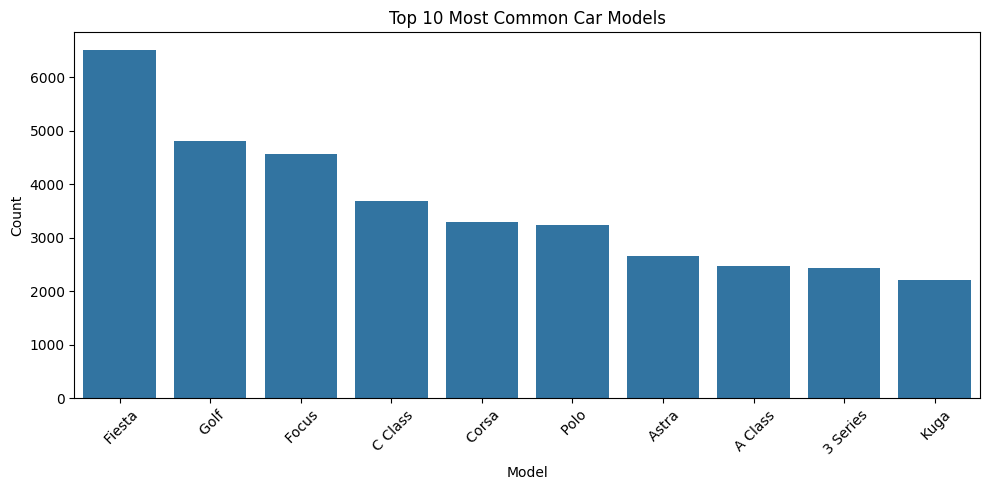

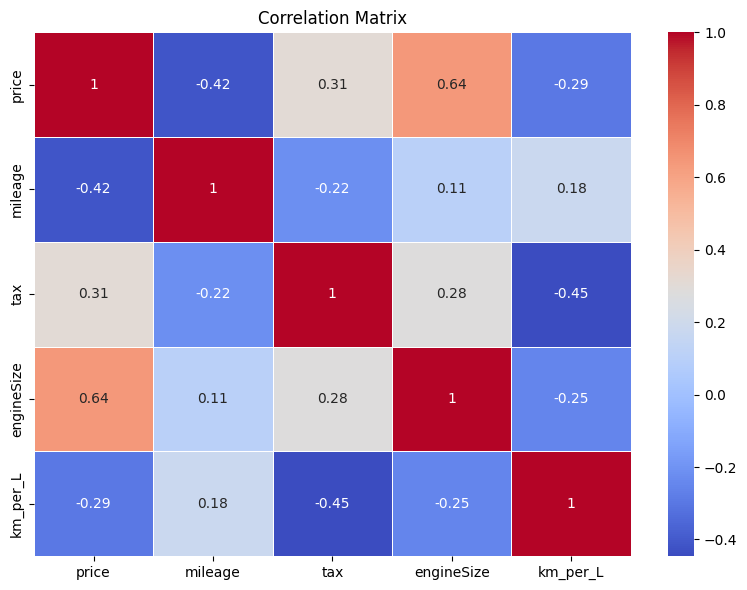

In [6]:


fuel_counts = df['fuelType'].value_counts()
labels = fuel_counts.index.tolist()
sizes  = fuel_counts.values
explode = [0.1 if lab == 'Electric' else 0 for lab in labels]

plt.figure(figsize=(8,8))
plt.pie(
    sizes,
    labels=labels,
    explode=explode,
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85,
    labeldistance=1.05
)
plt.title('Fuel Type Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()


trans_counts = df['transmission'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(
    trans_counts.values,
    labels=trans_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85,
    labeldistance=1.05
)
plt.title('Transmission Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()


price_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(
    price_by_year['year'],
    price_by_year['price'],
    marker='o',
    linestyle=':',
    linewidth=2
)
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Price (SAR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
sns.countplot(
    data=df,
    x='Manufacturer',
    order=df['Manufacturer'].value_counts().index
)
plt.xticks(rotation=90)
plt.title('Number of Cars by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


top_models = df['model'].value_counts().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_models.index, y=top_models.values)
plt.title('Top 10 Most Common Car Models')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,6))
corr = df[['price', 'mileage', 'tax', 'engineSize', 'km_per_L']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()




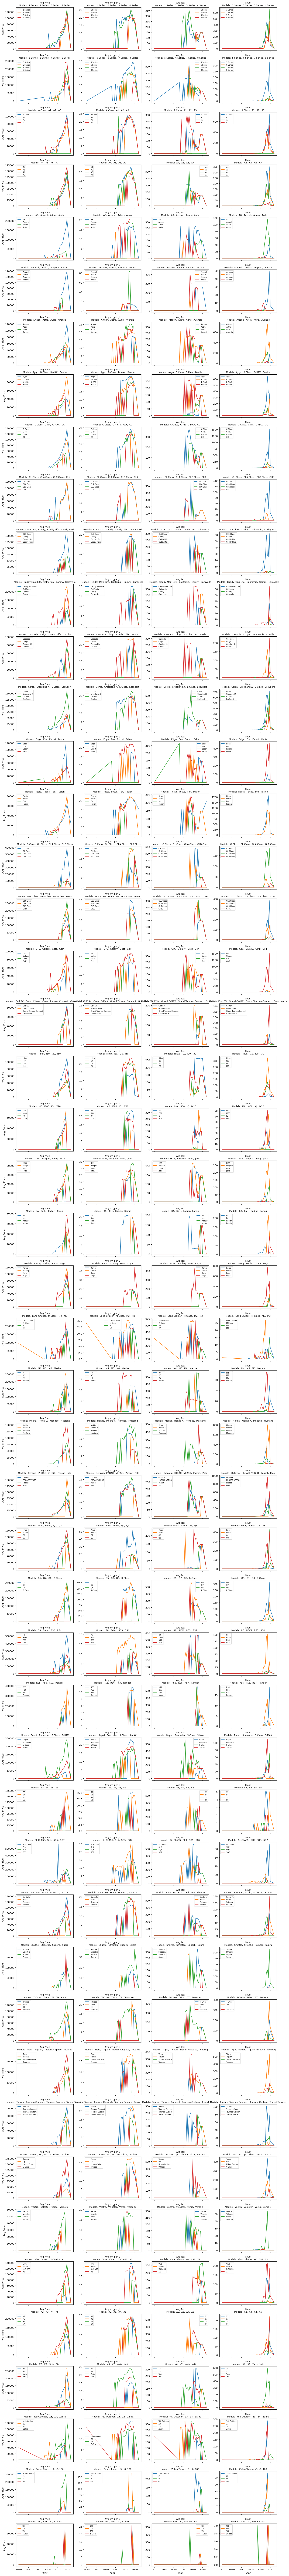

In [7]:
import math


pivot_mean = df.pivot_table(
    index='model',
    columns='year',
    values=['price', 'km_per_L', 'tax'],
    aggfunc='mean',
    fill_value=0
)
pivot_count = df.pivot_table(
    index='model',
    columns='year',
    values='price',
    aggfunc='count',
    fill_value=0
)


pivot_metrics = {
    'Avg Price':    pivot_mean['price'].T,
    'Avg km_per_L': pivot_mean['km_per_L'].T,
    'Avg Tax':      pivot_mean['tax'].T,
    'Count':        pivot_count.T
}


models = pivot_mean['price'].index.tolist()
groups = [models[i:i+4] for i in range(0, len(models), 4)]


n_rows = len(groups)
n_cols = len(pivot_metrics)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*4, n_rows*3),
                         sharex=True)

if n_rows == 1:
    axes = axes[np.newaxis, :]
if n_cols == 1:
    axes = axes[:, np.newaxis]


for i, grp in enumerate(groups):
    for j, (metric_name, df_metric) in enumerate(pivot_metrics.items()):
        ax = axes[i, j]
        df_metric[grp].plot(ax=ax)
        ax.set_title(f"{metric_name}\nModels: {', '.join(grp)}", fontsize=9)
        if i == n_rows-1:
            ax.set_xlabel('Year')
        if j == 0:
            ax.set_ylabel(metric_name)
        ax.legend(loc='best', fontsize='x-small')

plt.tight_layout()
plt.show()